# Exercise B: fine-tuning EfficientNet for identifying pneumonia in chest scans

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random
from PIL import Image
import torchvision.transforms as tfms
from torchsummary import summary


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/ML_2023/MLCourse_2023/Tutorial4/

/content/drive/MyDrive/ML_2023/MLCourse_2023/Tutorial4


### Download the Chest X-Ray Images (Pneumonia) dataset
- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- https://doi.org/10.1016/j.cell.2018.02.010

In [ ]:
#!wget https://www.dropbox.com/s/di6j323078za4qd/chest_xray.zip?dl=0

In [ ]:
#!unzip chest_xray.zip

In [8]:
#images_normal_train = glob.glob('chest_xray/train/NORMAL/*.jpeg')
#images_pneumo_train = glob.glob('chest_xray/train/PNEUMONIA/*.jpeg')
images_normal_valid = glob.glob('chest_xray/val/NORMAL/*.jpeg')
images_pneumo_valid = glob.glob('chest_xray/val/PNEUMONIA/*.jpeg')
images_normal_test = glob.glob('chest_xray/test/NORMAL/*.jpeg')
images_pneumo_test = glob.glob('chest_xray/test/PNEUMONIA/*.jpeg')

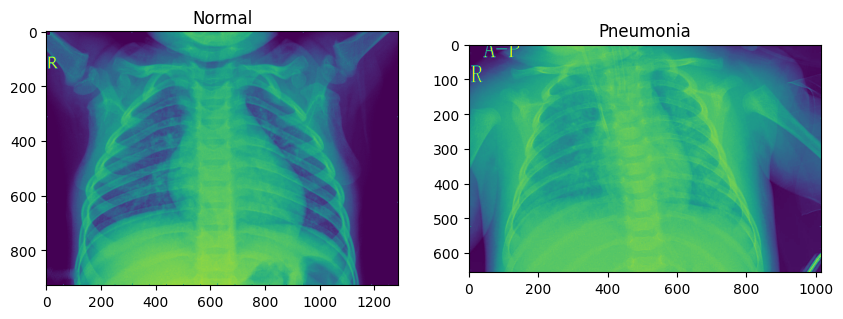

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(plt.imread(images_normal_valid[random.randint(0,len(images_normal_valid)-1)]))
axes[0].set_title('Normal')
axes[1].imshow(plt.imread(images_pneumo_valid[random.randint(0,len(images_pneumo_valid)-1)]))
axes[1].set_title('Pneumonia')
plt.show()

In [10]:
class ChestData(Dataset):

    def __init__(self, images_normal, images_pneumo):

        self.images = images_normal + images_pneumo
        self.labels = [0]*len(images_normal) + [1]*len(images_pneumo)
    
    def __len__(self):

        return len(self.labels)
    
    def  __getitem__(self, idx):

        img = Image.open(self.images[idx]).convert('RGB')
        lbl = self.labels[idx]

        transform = tfms.Compose([
            tfms.ToTensor(),
            tfms.Resize((256,256)),
            tfms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225]),
        ])

        img_tensor = transform(img)
        return img_tensor, lbl

In [11]:
train_dataset = DataLoader(ChestData(images_normal_test, images_pneumo_test), batch_size=16, shuffle=True)
valid_dataset = DataLoader(ChestData(images_normal_valid, images_pneumo_valid), batch_size=16, shuffle=True)

### Define our pretrained model + custom backend

In [5]:
### Following https://blog.paperspace.com/detecting-and-localizing-pneumonia-from-chest-x-ray-scans-with-pytorch/
class TransferNet(nn.Module):
    def __init__(self,freeze_pretrained=True):
        super(TransferNet,self).__init__()

        ### The pretrained model
        pretrained_weights = models.get_weight("EfficientNet_B6_Weights.IMAGENET1K_V1")
        self.model = models.efficientnet_b6(weights=pretrained_weights)

        ### We can freeze the pretrained parameters
        if freeze_pretrained:
            for params in self.model.parameters():
                params.requires_grad = False

        ### Our new classifier layer
        self.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features,1),
            nn.Sigmoid()
        )

        ### Replace the previous classifier with our trainable one
        self.model.classifier = self.classifier

    def forward(self, x):
        return self.model(x)

In [12]:
net = TransferNet()

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth
100%|██████████| 165M/165M [00:04<00:00, 39.4MB/s]


In [13]:
Ntrainable = sum(p.numel() for p in net.classifier[0].parameters())
Ntrainable

2305

In [136]:
optimizer = torch.optim.Adam(net.classifier.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4)

In [137]:
Nepochs = 5
loss = nn.BCELoss()
losses_train = []
losses_valid = []

device = torch.device("cpu")
if torch.cuda.is_available():
  print('Found GPU!')
  device = torch.device("cuda:0")

net.to(device)

for epoch in range(Nepochs):

    #Training
    net.train()
    scheduler.step()
    losses_train_epoch = []

    for batch in tqdm(train_dataset):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = net(X).squeeze(-1)
        loss_train = loss(y_pred, y.float())
        loss_train.backward()
        optimizer.step()
        losses_train_epoch.append(loss_train.item())

    losses_train.append(np.mean(losses_train_epoch))

    #Validation
    net.eval()
    losses_valid_epoch = []

    with torch.no_grad():
        for batch in tqdm(valid_dataset):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X).squeeze(-1)
            loss_val = loss(y_pred, y.float())
            losses_valid_epoch.append(loss_val.item())

    losses_valid.append(np.mean(losses_valid_epoch))

    if epoch > 0:
        if losses_valid[-1] < min(losses_valid[:-1]):
            torch.save(net.state_dict(), 'saved_model.pt')

    print('Epoch: ',epoch,' Train loss: ',losses_train[-1],' Valid loss: ',losses_valid[-1])

Found GPU!


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.5472011734277774  Valid loss:  0.5928264260292053


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Train loss:  0.39180796001202023  Valid loss:  0.5153569579124451


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Train loss:  0.3249538942025258  Valid loss:  0.4819903075695038


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Train loss:  0.3225139727195104  Valid loss:  0.5184646844863892


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Train loss:  0.33321009156031484  Valid loss:  0.5916309952735901


### Load the best model from training

In [18]:
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
net.eval()
net.cpu()

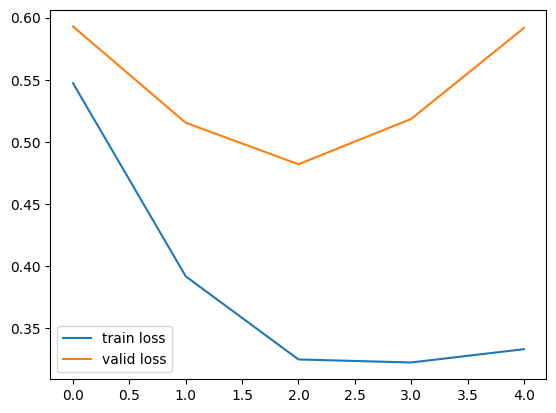

In [139]:
fig, axes = plt.subplots()
axes.plot(range(len(losses_train)),losses_train,label='train loss')
axes.plot(range(len(losses_valid)),losses_valid,label='valid loss')
axes.legend()
plt.show()

### Check accuracy

In [20]:
scores, preds = [], []
acc = 0

print("Label, Pred")
for example, label in ChestData(images_normal_valid, images_pneumo_valid):
    score = net(example.unsqueeze(0)).squeeze(-1).item()
    pred = 1 if score>0.5 else 0
    print(label,pred)
    if pred==label:
        acc += 1
    
    scores.append(score)
    preds.append(pred)

print('=============')
print(f'Got {acc}/{len(preds)} correct ({100*acc/len(preds)}%)')

Label, Pred


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 0
1 1
Got 12/16 correct (75.0%)


In [23]:
scores

[0.15850964188575745,
 0.14469167590141296,
 0.7597795724868774,
 0.5149987936019897,
 0.172023206949234,
 0.1791175901889801,
 0.38614949584007263,
 0.4942498505115509,
 0.9373313188552856,
 0.3338935971260071,
 0.6366596221923828,
 0.7021661996841431,
 0.6807534694671631,
 0.815699577331543,
 0.37368327379226685,
 0.8711492419242859]

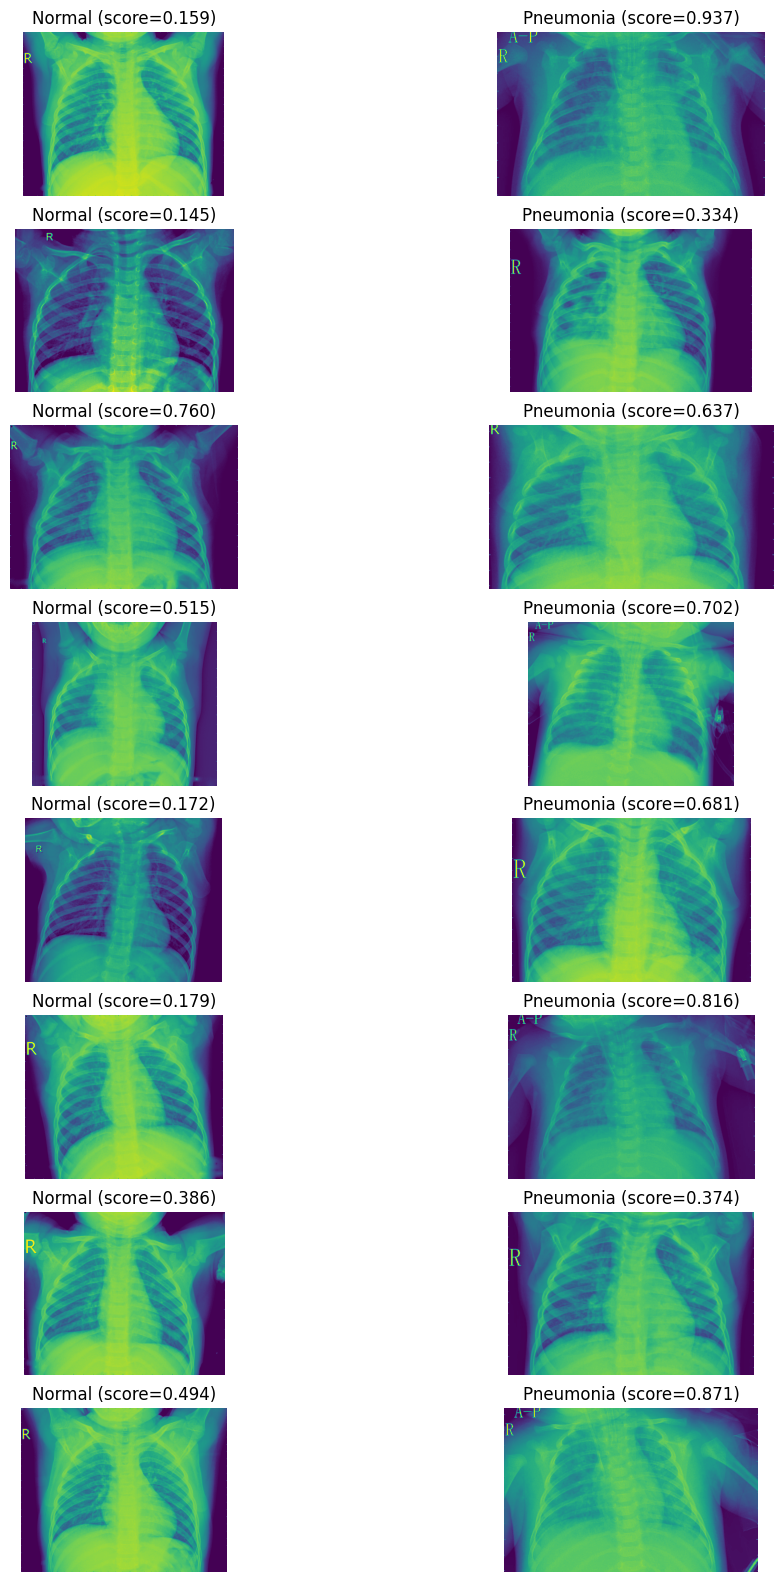

In [27]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))

for i in range(8):
    axes[i,0].imshow(plt.imread(images_normal_valid[i]))
    axes[i,0].set_title(f'Normal (score={scores[i]:.3f})')
    axes[i,0].set_axis_off()
    axes[i,1].imshow(plt.imread(images_pneumo_valid[i]))
    axes[i,1].set_title(f'Pneumonia (score={scores[i+8]:.3f})')
    axes[i,1].set_axis_off()

plt.show()